In [1]:
import numpy as np
import xarray as xr
from itertools import product
import hexMinisom
import matplotlib.pyplot as plt
import pickle
import sammon
import itertools
import colorsys
import random
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from scipy import stats

In [2]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)
    return som

def generate_distinct_colors(n):
    colors = []
    
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        colors.append(hex_color)

    random.shuffle(colors)
    return colors

# convert our hex coordinates into cube coordinate
def oddr_to_cube(row, col):
    q = col - (row - (row&1)) / 2
    r = row
    return (q, r, -q-r)

# calculate the distance between two nodes
def calc_transition_distance(s, e):

    s = oddr_to_cube(s[0], s[1])
    e = oddr_to_cube(e[0], e[1])
    
    dist = (abs(s[0] - e[0]) + abs(s[1] - e[1]) + abs(s[2] - e[2])) / 2
    return dist

In [3]:
dataset = xr.open_dataarray('/glade/work/molina/DATA/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

# Seasonal breakdown of the data
DJF = dataset.time.dt.month.isin([12, 1, 2])
DJF_idxs = np.array(DJF).nonzero()[0]
MAM = dataset.time.dt.month.isin([3, 4, 5])
MAM_idxs = np.array(MAM).nonzero()[0]
JJA = dataset.time.dt.month.isin([6, 7, 8])
JJA_idxs = np.array(JJA).nonzero()[0]
SON = dataset.time.dt.month.isin([9, 10, 11])
SON_idxs = np.array(SON).nonzero()[0]

print(dataarray.shape)

(30660, 9211)


In [4]:
som = load_som('SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

# List of regimes for each day in order
neuronList = []
for i, x in enumerate(dataarray):
    neuronList.append(som.winner(x))

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

# Calculate the node number for each coordinate
node_nums = {}
n = 1
for i in range(mask.shape[0])[::-1]:
    for j in range(mask.shape[1]):
        # only use non masked nodes
        if som._mask[i, j] == 0:
            node_nums[(i, j)] = n
            n += 1

color_list = generate_distinct_colors(len(node_indices))

TolFun exceeded: Optimisation terminated


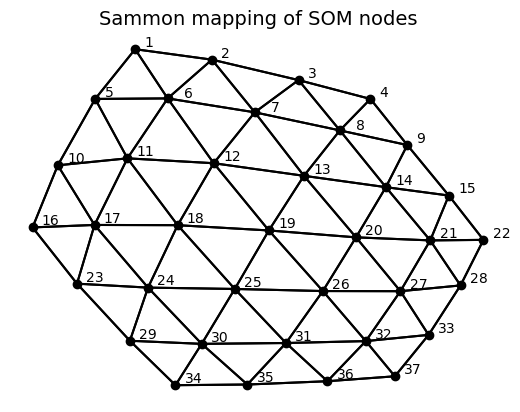

In [5]:
# Locations from sammon mapping will be used as node locations in our graph visualization
# Find the edges between nodes
edgeCoordinates = []
for i, node in enumerate(node_indices):
    x, y = node
    adj = [(x-1, y), (x+1, y), (x,y-1), (x,y+1)]
    
    if node[0] % 2 == 0:
        adj.append((x+1, y-1))
        adj.append((x-1, y-1))
        
    else:
        adj.append((x+1, y+1))
        adj.append((x-1, y+1))
    
    adj = [(i, node_indices.index((x, y))) for x, y in adj if (x, y) in node_indices]
    edgeCoordinates.extend(adj)

# gets the weights of each node into the order of node_indices
weights = som.get_weights()[node_indices_xy[0], node_indices_xy[1]]

# Run the Sammon projection
[y,E] = sammon.sammon(weights, 2, display=1)
y = np.array(list(y))

# Rotate and flip the points to be oriented the same as other figures
# First rotation by ~ pi/3 to rotate hexagon by one side
theta = 2 * np.pi / 7
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
y = np.transpose(np.matmul(rotation_matrix, np.transpose(y)))
# Flip the x-axis
y[:, 0] = -1 * (y[:, 0] - np.mean(y[:, 0]))

# Plot the centers of the nodes
plt.scatter(y[:, 0], y[:, 1], color='black')

# plot the connections of each node as a line
for s, e in edgeCoordinates:
    plt.plot(y[[s,e], 0], y[[s,e], 1], color='black')

# Label the Nodes
for i, n in enumerate(node_indices):
    if node_nums[n] in [6, 7, 8]:
        plt.annotate(str(node_nums[n]), (y[i, 0] + 4, y[i, 1] + .5))
    else:
        plt.annotate(str(node_nums[n]), (y[i, 0] + 2.25, y[i, 1] + 1))

plt.axis("off")
plt.title('Sammon mapping of SOM nodes', fontsize=14)

plt.savefig('Sammon.pdf', transparent=True, bbox_inches='tight')
plt.show()